In [1]:
import cvxpy as cvx

# Create two scalar optimization variables.
x = cvx.Variable()
y = cvx.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cvx.Minimize(cvx.square(x - y))

# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print "status:", prob.status
print "optimal value", prob.value
print "optimal var", x.value, y.value

status: optimal
optimal value 0.999999999762
optimal var 1.00000000001 -1.20824129796e-11


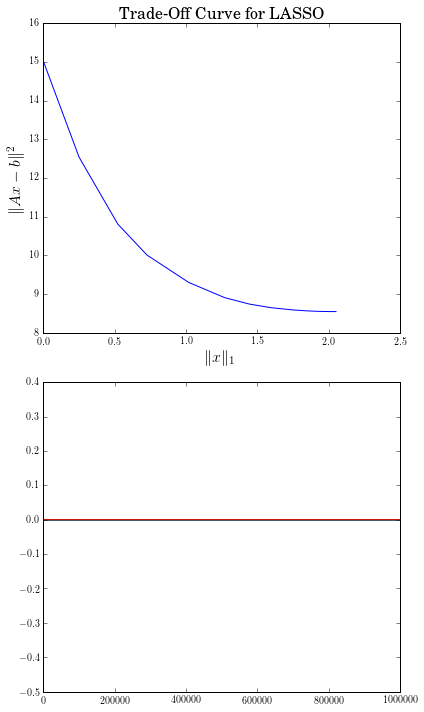

In [4]:
%matplotlib inline

from cvxpy import *
import numpy
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 10
numpy.random.seed(1)
A = numpy.random.randn(n, m)
b = numpy.random.randn(n, 1)
# gamma must be positive due to DCP rules.
gamma = Parameter(sign="positive")

# Construct the problem.
x = Variable(m)
error = sum_squares(A*x - b)
obj = Minimize(error + gamma*norm(x, 1))
prob = Problem(obj)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []
gamma_vals = numpy.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(norm(x, 1).value)
    x_values.append(x.value)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(6,10))

# Plot trade-off curve.
plt.subplot(211)
plt.plot(l1_penalty, sq_penalty)
plt.xlabel(r'\|x\|_1', fontsize=16)
plt.ylabel(r'\|Ax-b\|^2', fontsize=16)
plt.title('Trade-Off Curve for LASSO', fontsize=16)

# Plot entries of x vs. gamma.
plt.subplot(212)
for i in range(m):
    plt.plot(gamma_vals, [xi[i,0] for xi in x_values])

plt.tight_layout()

In [1]:
%matplotlib inline
import os, socket
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (7,7)

In [7]:
import cvxpy as cvx

In [2]:
import neuralyzer
from neuralyzer.im import smff

In [3]:
if socket.gethostname() == 'kumo':
    #datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel0.tif'
    #datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
    datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_minitestdata.tif'
else:
    #datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
    datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_minitestdata.tif'
data = neuralyzer.get_data(datafile, library='tifffile')

[ 2015-04-23 16:58:21 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-23 16:58:21 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-23 16:58:21 ] [ data_handler ] [ DEBUG ] : root_path set to /Users/michael/coding/RIKEN/lib/neuralyzer/notebooks/dev
[ 2015-04-23 16:58:21 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel1_minitestdata.tif.hdf5


In [4]:
A = data.reshape(data.shape[0], data.shape[1]*data.shape[2])

In [5]:
m, n = A.shape
k = 50 # number of components

# Initialize Y randomly.
Y_init = np.random.rand(m, k)

In [ ]:
# Perform alternating minimization.
Y = Y_init
MAX_ITERS = 30
residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1+MAX_ITERS):
    # At the beginning of an iteration, X and Y are NumPy
    # array types, NOT CVXPY variables.

    # For odd iterations, treat Y constant, optimize over X.
    if iter_num % 2 == 1:
        X = cvx.Variable(k, n)
        constraint = [X >= 0]
    # For even iterations, treat X constant, optimize over Y.
    else:
        Y = cvx.Variable(m, k)
        constraint = [Y >= 0]
    
    # Solve the problem.
    obj = cvx.Minimize(cvx.norm(A - Y*X, 'fro'))
    prob = cvx.Problem(obj, constraint)
    prob.solve(solver=cvx.SCS)

    if prob.status != cvx.OPTIMAL:
        raise Exception("Solver did not converge!")
    
    print 'Iteration {}, residual norm {}'.format(iter_num, prob.value)
    residual[iter_num-1] = prob.value

    # Convert variable to NumPy array constant for next iteration.
    if iter_num % 2 == 1:
        X = X.value
    else:
        Y = Y.value